In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization,
    Activation
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from keras.applications import VGG16

In [22]:
def no_of_subdirs(directory,set_name):
    counts={}
    for item in os.listdir(directory):
        item_path=os.path.join(directory,item)
        if os.path.isdir(item_path):
            counts[item]=len(os.listdir(item_path))
    df=pd.DataFrame(counts,index=[set_name])
    return df

In [23]:
train_dataset='train'
test_dataset='test'
train_count=no_of_subdirs(train_dataset,'train')
test_count=no_of_subdirs(test_dataset,'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


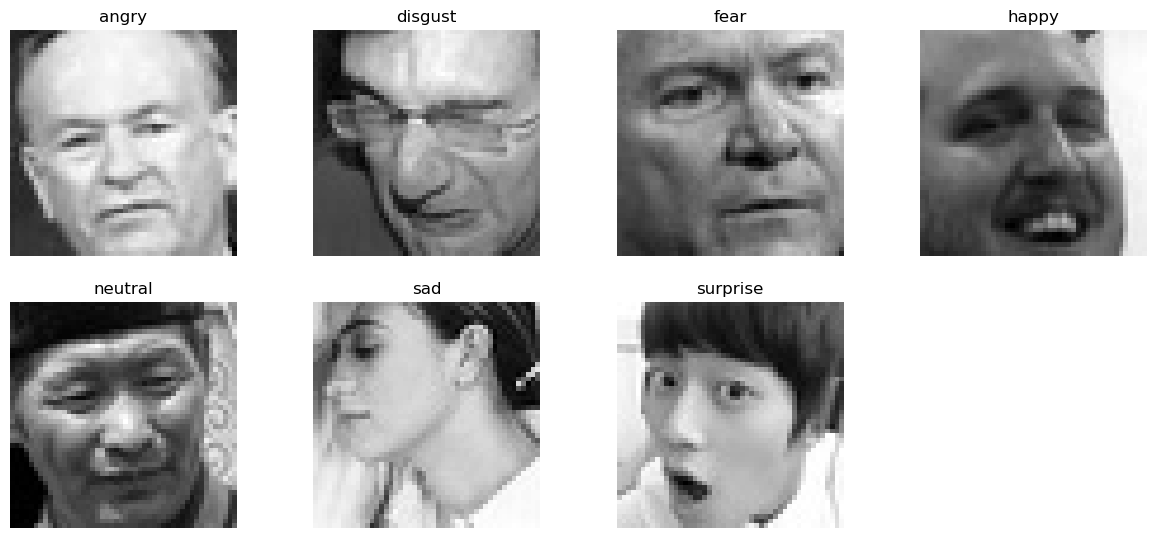

In [24]:
emotions=os.listdir(train_dataset)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
    folder=os.path.join(train_dataset,emotion)
    img_path=os.path.join(folder,os.listdir(folder)[6])
    img=plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [25]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:

def load_dataset(directory, subset, target_size, batch_size, class_mode):
    return train_datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        class_mode=class_mode,
        subset=subset,
        batch_size=batch_size
    )

train_dataset = load_dataset(
    'train',
    'training',
    (48, 48),
    64,
    'categorical'
)
valid_dataset = load_dataset(
    'train',
    'validation',
    (48, 48),
    64,
    'categorical'
)

test_dataset = load_dataset(
    'test',
    None,
    (48, 48),
    64,
    'categorical'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:

base_model = VGG16(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet"
)


for layer in base_model.layers[:-4]:
    layer.trainable = False

In [51]:
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax')
])

In [52]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
model.build(input_shape=(None, 48, 48, 3))


In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 32)                16416     
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 32)               

In [55]:
def f1_score(y_true, y_pred):

    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    

    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    

    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1_val


In [56]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

lrd = ReduceLROnPlateau(
    monitor='val_loss',
    patience=20,
    verbose=1,
    factor=0.50,
    min_lr=1e-10
)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(
    verbose=1,
    patience=20
)

In [67]:

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    verbose=1,
    callbacks=[lrd, mcp, es]
)

Epoch 1/30
359/359 [==============================] - 133s 366ms/step - loss: 1.5874 - accuracy: 0.8669 - precision: 0.6469 - recall: 0.1498 - auc: 0.7644 - f1_score: 0.2382 - val_loss: 1.5692 - val_accuracy: 0.8687 - val_precision: 0.7204 - val_recall: 0.1324 - val_auc: 0.7706 - val_f1_score: 0.2226 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - 130s 362ms/step - loss: 1.5748 - accuracy: 0.8683 - precision: 0.6735 - recall: 0.1522 - auc: 0.7678 - f1_score: 0.2471 - val_loss: 1.5960 - val_accuracy: 0.8681 - val_precision: 0.7597 - val_recall: 0.1123 - val_auc: 0.7602 - val_f1_score: 0.1937 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - 130s 361ms/step - loss: 1.5619 - accuracy: 0.8693 - precision: 0.6827 - recall: 0.1590 - auc: 0.7727 - f1_score: 0.2569 - val_loss: 1.5622 - val_accuracy: 0.8692 - val_precision: 0.6945 - val_recall: 0.1505 - val_auc: 0.7728 - val_f1_score: 0.2463 - lr: 0.0010
Epoch 4/30
359/359 [==============================] - 1

In [66]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         name='Accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy',
                  legend=dict(x=0.7, y=0.9),
                  width=800,
                  height=600,
                  plot_bgcolor='rgb(17, 17, 17)',
                  paper_bgcolor='rgb(17, 17, 17)',
                  font=dict(color='white'))
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [16]:
print("\nEvaluating the model on the test dataset...")
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_dataset)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Evaluating the model on the test dataset...
  1/113 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.8772 - auc: 0.8830 - f1_score: 0.3210 - loss: 1.2199 - precision: 0.7647 - recall: 0.2031

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - accuracy: 0.8759 - auc: 0.8211 - f1_score: 0.3470 - loss: 1.4224 - precision: 0.6963 - recall: 0.2328

Test Loss: 1.4235
Test Accuracy: 0.8757
Test Precision: 0.6916
Test Recall: 0.2340
Test AUC: 0.8204
Test F1 Score: 0.3463


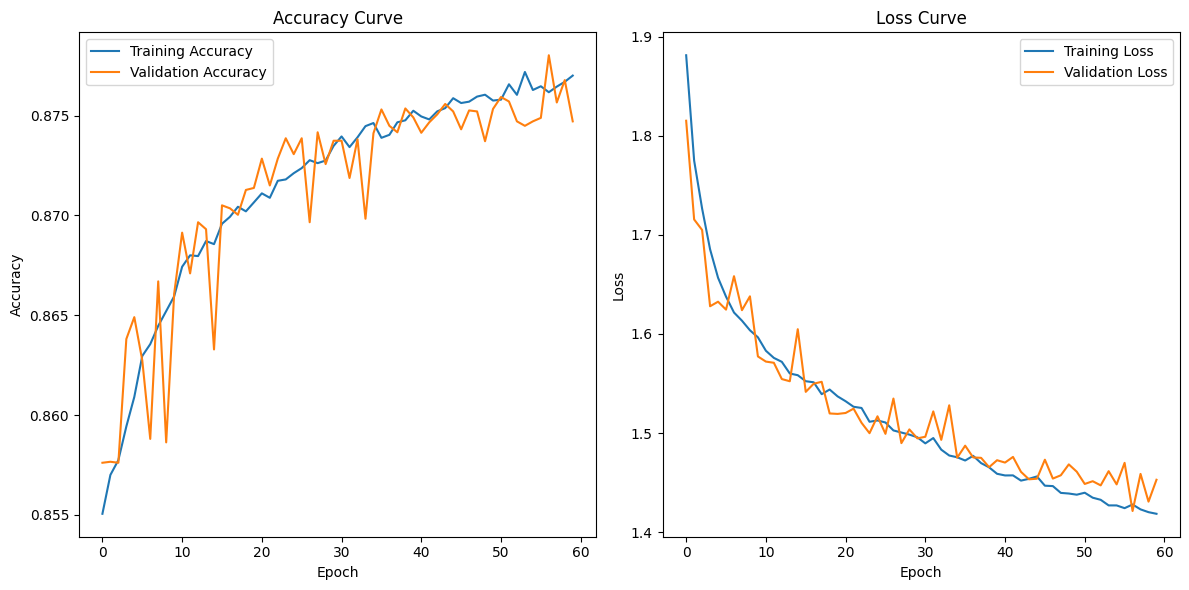

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

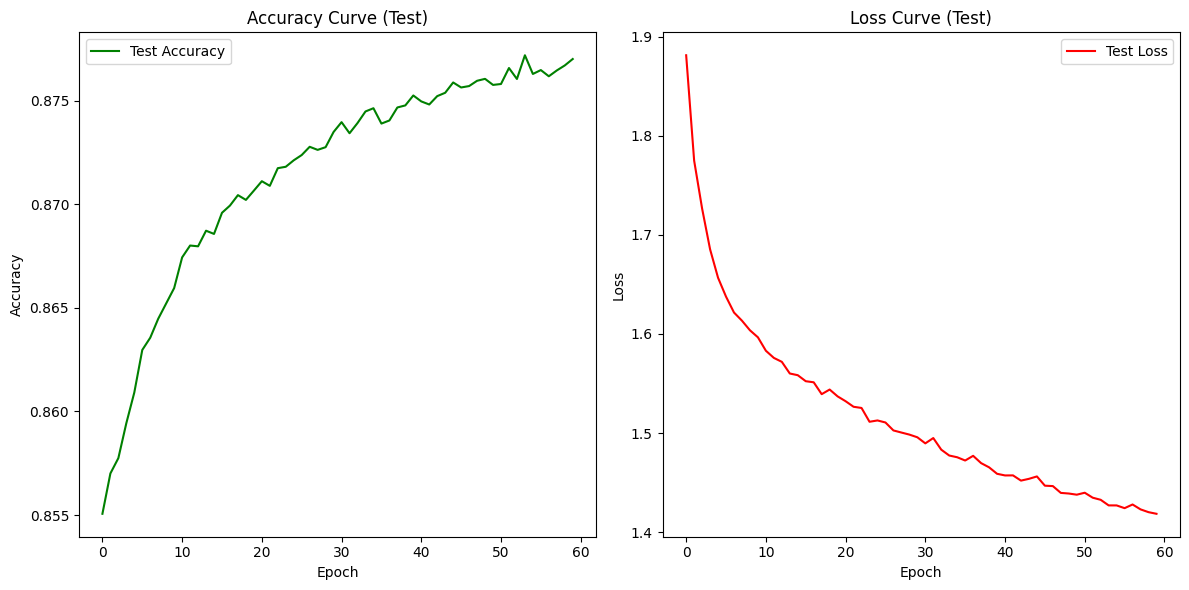

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Test Accuracy', color='green')
plt.title('Accuracy Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Test Loss', color='red')
plt.title('Loss Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()

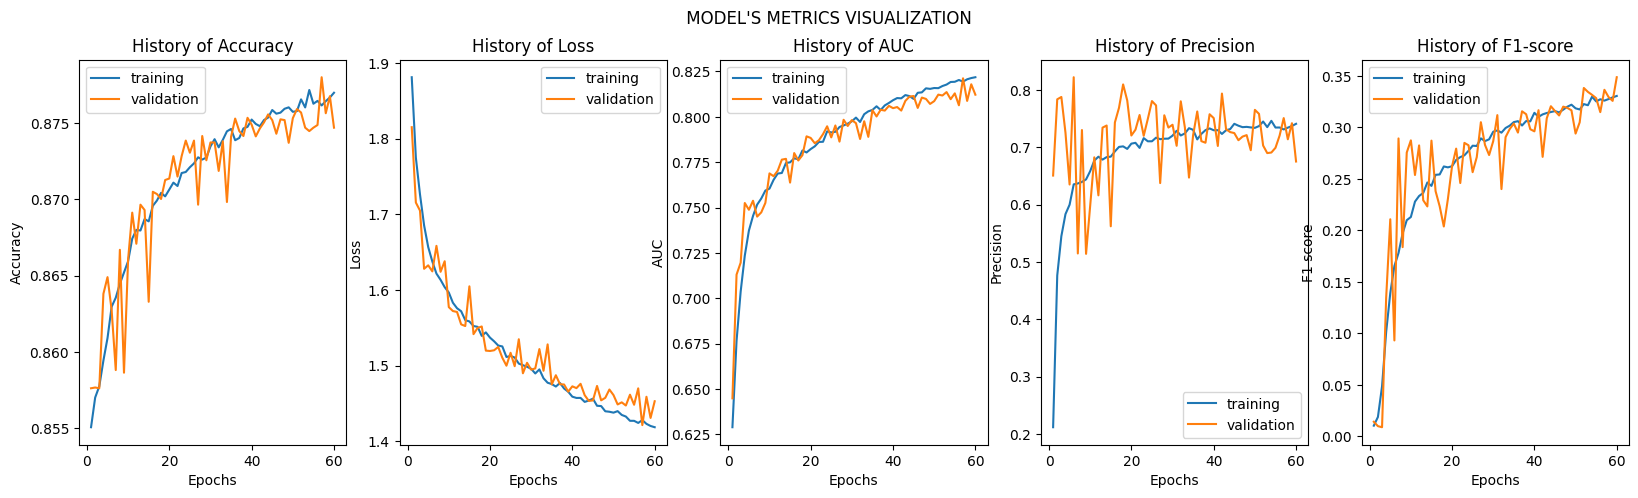

In [20]:

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

2/2 [==============================] - 0s 141ms/step
64


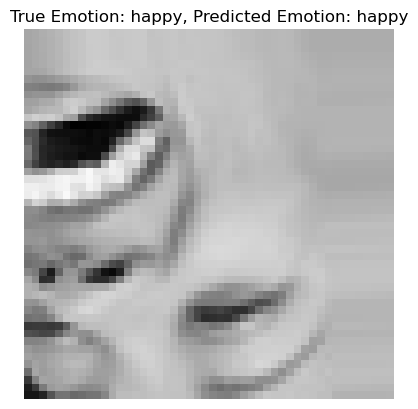

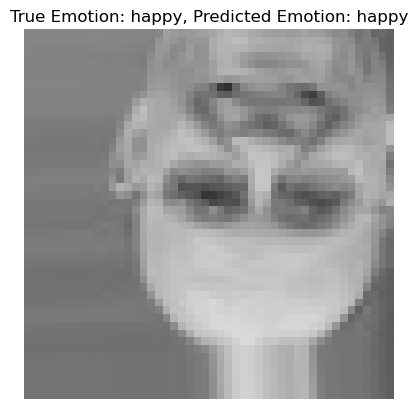

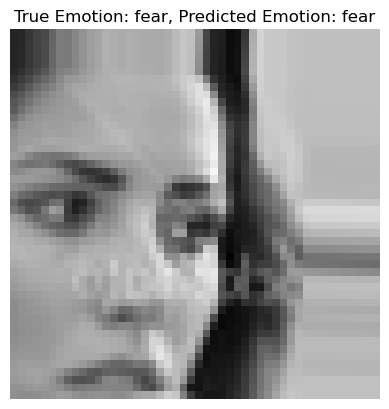

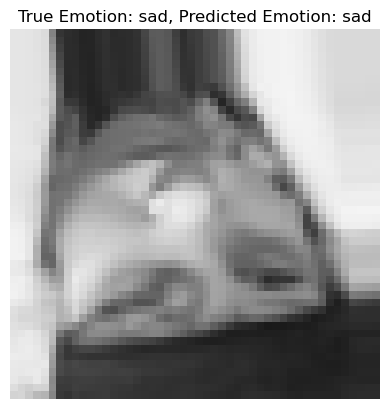

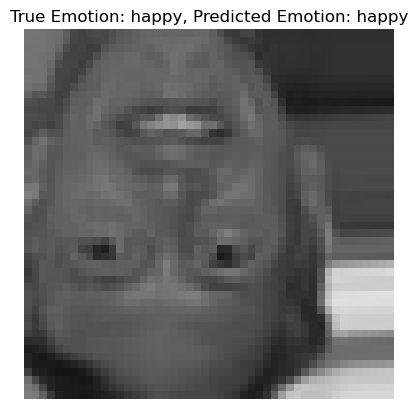

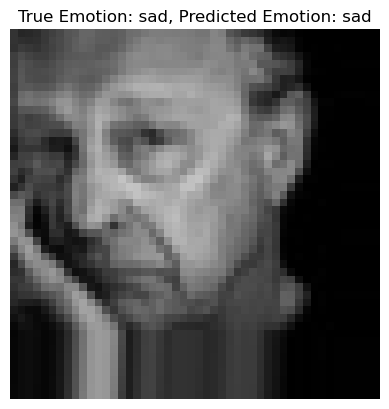

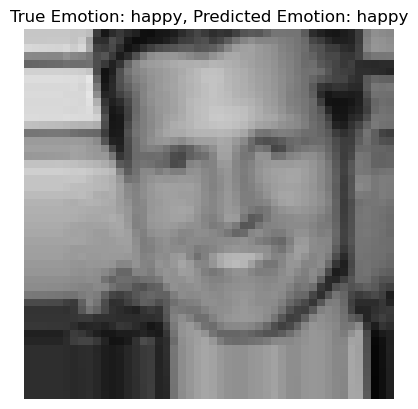

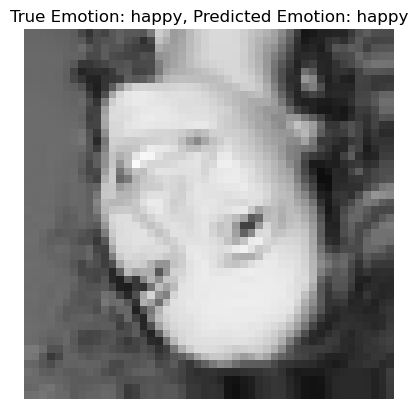

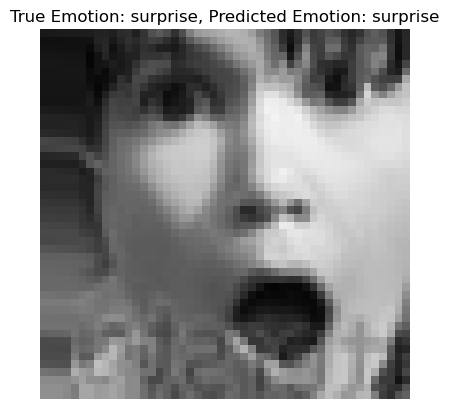

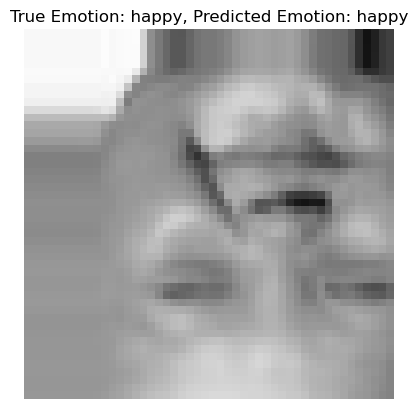

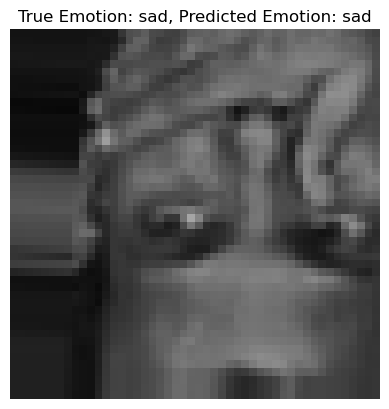

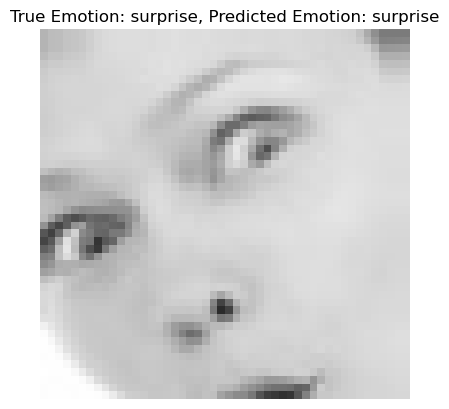

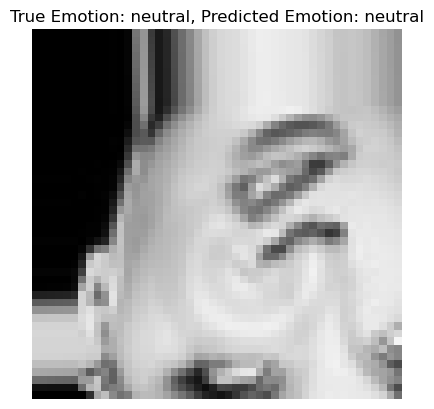

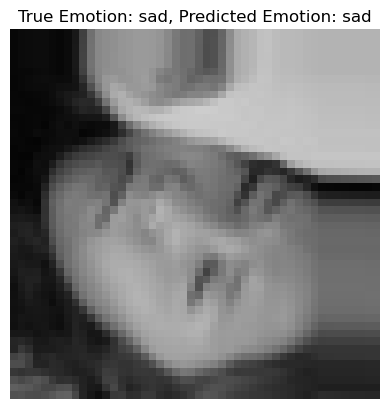

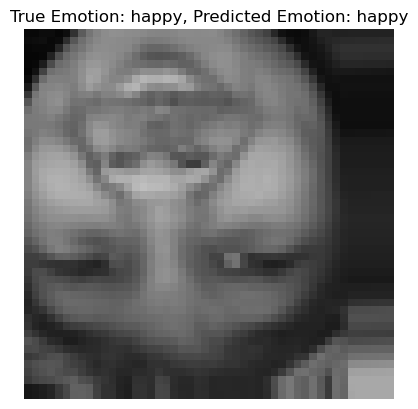

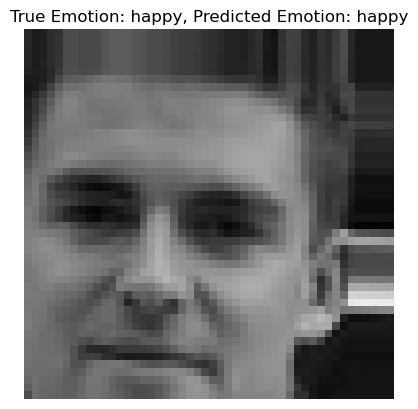

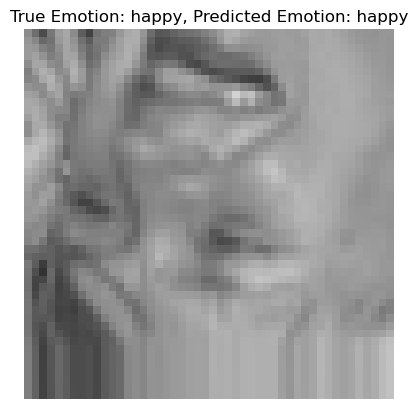

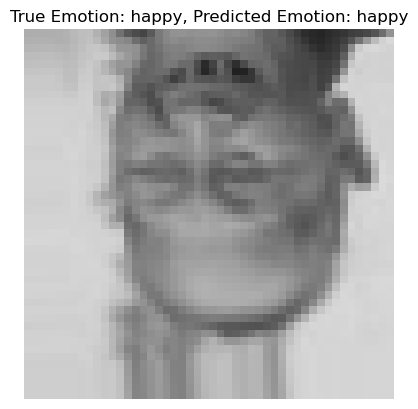

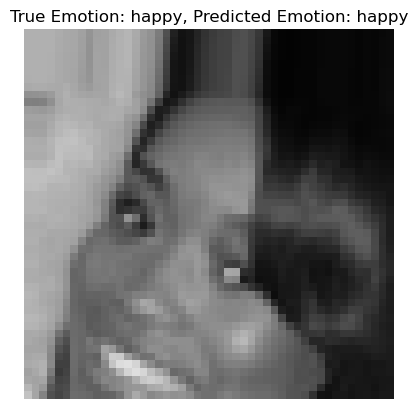

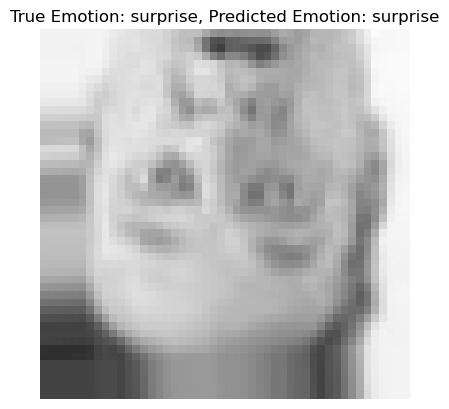

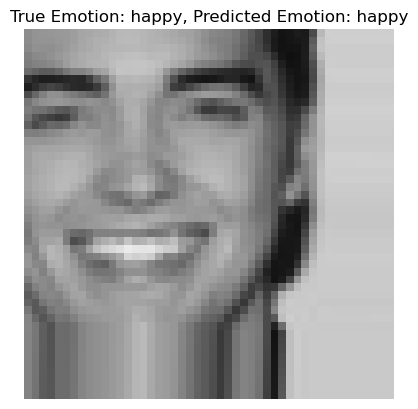

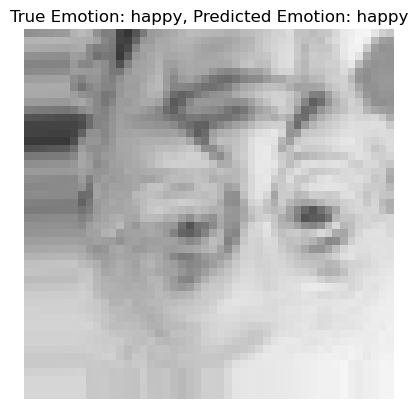

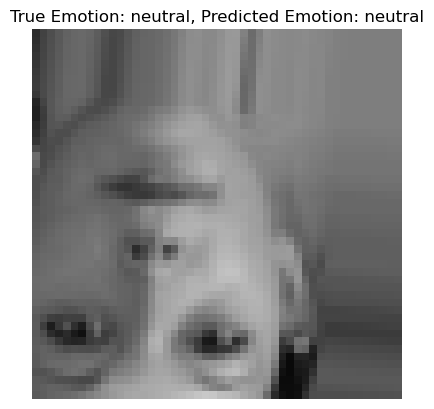

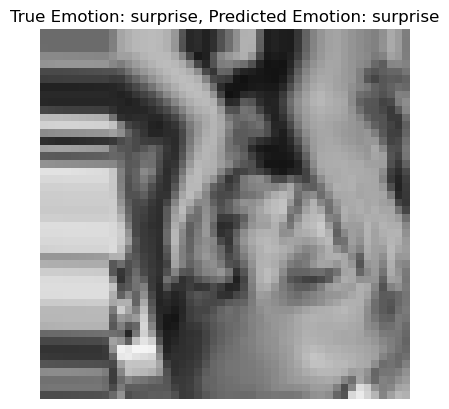

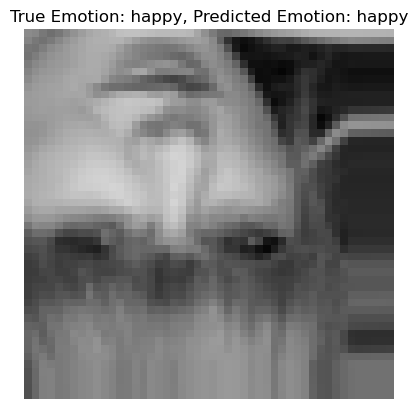

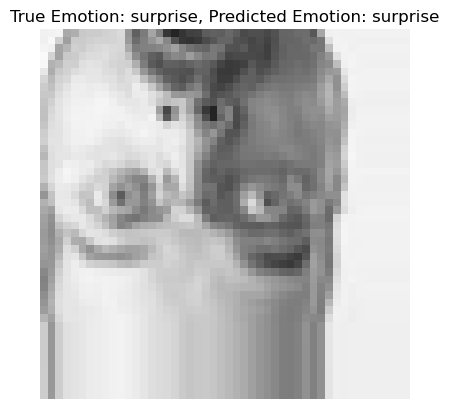

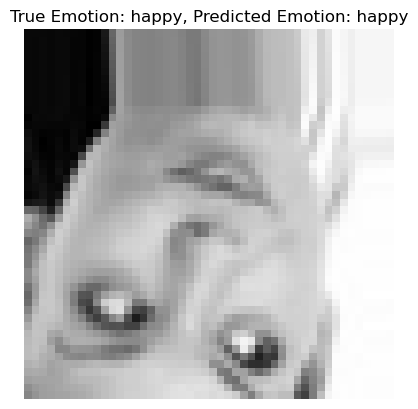

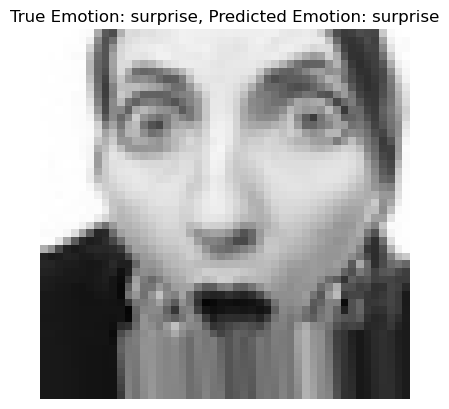

28


In [61]:
for images, labels in test_dataset:

    predictions = model.predict(images)
    predicted_emotions = np.argmax(predictions, axis=1)
    class_labels = test_dataset.class_indices
    emotion_labels = {value: key for key, value in class_labels.items()}
    print(len(images))
    coun = 0
    for i in range(len(images)):
        image = images[i]
        true_emotion = emotion_labels[np.argmax(labels[i])]
        predicted_emotion = emotion_labels[predicted_emotions[i]]
        
        if(true_emotion == predicted_emotion):
            coun = coun + 1
            plt.imshow(image)
            plt.title(f'True Emotion: {true_emotion}, Predicted Emotion: {predicted_emotion}')
            plt.axis('off')
            plt.show()
    print(coun)
    break


In [33]:
import gradio as gr

In [62]:
def classify(inp):
    print(inp.shape)
    inp = inp.reshape(-1,48,48,3)
    predictions = model.predict(inp).flatten()
    print(predictions)
    return {emotions[i]: float(predictions[i]) for i in range(7)}
image = gr.Image(width=480,height=480)
label = gr.Label(num_top_classes=3)

In [63]:
emotions

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [64]:
iface = gr.Interface(fn=classify, inputs=image, outputs=label)
iface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


(48, 48, 3)
1/1 [==============================] - 0s 232ms/step
[1.41940871e-03 7.83466476e-06 3.78017686e-03 9.70811248e-01
 1.13586765e-02 1.99000794e-03 1.06328325e-02]
(48, 48, 3)
1/1 [==============================] - 0s 51ms/step
[8.4062934e-10 2.1269766e-14 4.1423995e-08 9.9999177e-01 2.4349497e-06
 2.3201094e-09 5.8854716e-06]
(48, 48, 3)
1/1 [==============================] - 0s 53ms/step
[1.7371447e-29 0.0000000e+00 2.0781835e-24 1.0000000e+00 6.8881877e-18
 2.0910626e-27 7.9905291e-18]
(48, 48, 3)
1/1 [==============================] - 0s 63ms/step
[9.0931775e-05 6.4242192e-07 3.4638238e-04 9.9561113e-01 2.6488828e-03
 2.1389083e-04 1.0882673e-03]
(48, 48, 3)
1/1 [==============================] - 0s 47ms/step
[1.2217102e-03 1.1467255e-05 1.5231038e-02 4.5872293e-02 8.8758701e-03
 3.8666351e-04 9.2840099e-01]
(48, 48, 3)
1/1 [==============================] - 0s 54ms/step
[6.3056848e-03 7.4420559e-06 1.6528049e-01 8.4792315e-05 5.2778553e-03
 1.6298146e-03 8.2141387e-01]
(4